### **Workshop Structure**
This workshop use a deep neural network for classification as an example, focusing on how to tweak the neural networks in order to extract the maximum accuracy out of them.

We will see the three major parts spanned in this notebook:

* We will be covering the practical aspects of deep learning. We will see how to split the training, validation and test sets from the given data. We will also be covering topics like regularization, dropout, normalization, etc. that help us make our model more efficient.
* We will discuss the concept of a mini-batch gradient descent and a few more optimizers like Momentum, RMSprop, and ADAM.
* We will see how different hyperparameters can be tuned to improve the model’s efficiency. We will also cover the concept of Batch Normalization and how to solve a multi-class classification challenge.

## **An example**
We are going to work with feed-forward networks similar to the picture adopted from Wikimedia below.
![ Diagram of a Convolutional Neural Network](https://drive.google.com/uc?id=1l_2U8B6rjMEd86GI9f4OLGH8Ih6K00EY)

The image shows you that you feed an image as an input to the network, which goes through multiple convolutions, subsampling, a fully connected layer and finally outputs something.
<br><br>
#### **The Fashion-MNIST dataset**
Fashion-MNIST is similar to the MNIST dataset that collects Zalando's article images, with 28x28 grayscale images of 70,000 fashion products from 10 categories, and 7,000 images per category. The training set has 60,000 images, and the test set has 10,000 images.

### **Loading and preparing the data**

In [1]:
## Load the data
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

In [2]:
## Analyze the data
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


Text(0.5, 1.0, 'Ground Truth : 9')

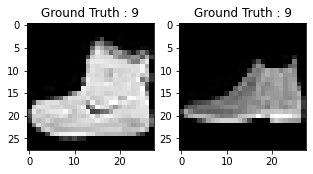

In [3]:
### Visualize the image examples

plt.figure(figsize=[5,5])

# Display the last image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the last image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

The output of above two plots look like boots, and this class is assigned a class label of 9. Similarly, other fashion products will have different labels, but similar products will have same labels. 

#### **Labels**
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


#### **Data preproessing**

In [4]:
## data reshaping
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
print(train_X.shape, test_X.shape)

## Data format changing and normalization (data scaling)
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)


(60000, 28, 28, 1) (10000, 28, 28, 1)


In [5]:
### Split the training data into two parts, one designed for training and another one for validation. 
### In this case, you will train the model on 80% of the training data and validate it on 20% of the remaining training data.
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(48000, 28, 28, 1) (12000, 28, 28, 1) (48000, 10) (12000, 10)


### **A simple convolutional neural network**
![the network architecture](https://drive.google.com/uc?id=1BWIwxK3qmCnhvqc8qWqZkAnhWMjv4CQE)

In [6]:
## The images are of size 28 x 28. You convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, and feed this as an input to the network. 
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

#################################
# The neural network architecture
#################################
num_classes = 10

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))   
fashion_model.add(Dense(num_classes, activation='softmax'))              

In [7]:
### Model compiling
opt = keras.optimizers.Adam(learning_rate=0.0005) ## optimizer options: see https://keras.io/api/optimizers/
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt,metrics=['acc'])

In [8]:
fashion_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         7

### **Understand model performance**
#### Train the model

In [9]:
### It's time to train the model with Keras' fit() function
#### some hyperparameters ######
batch_size = 64
epochs = 20

fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.5299 - acc: 0.8067 - val_loss: 0.3727 - val_acc: 0.8620
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3329 - acc: 0.8800 - val_loss: 0.3157 - val_acc: 0.8843
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2810 - acc: 0.8975 - val_loss: 0.2835 - val_acc: 0.8975
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2500 - acc: 0.9096 - val_loss: 0.2569 - val_acc: 0.9084
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2233 - acc: 0.9192 - val_loss: 0.2501 - val_acc: 0.9062
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2036 - acc: 0.9252 - val_loss: 0.2421 - val_acc: 0.9105
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.1856 - acc: 0.9316 - val_loss: 0.2450 - val_acc: 0.9115
Epoch 8/20
750/750 [==============================] - 4s 5ms/step - loss: 0.

You trained the model on fashion-MNIST for 20 epochs by observing the training accuracy and loss

### Check for overfitting
* We can first ensure the neural network performs well on the testing data to verify that the neural network does not overfit. <br>
* What is overfitting? <br>
<I><font color=7714e6> In machine learning, overfitting is a phenomenon where a machine learning model models the training data too well but fails to perform well on the testing data. Performing sufficiently good on testing data is considered as a kind of ultimatum in machine learning.


![alt text](https://drive.google.com/uc?export&id=1FiZDQG5RngJb7CAa8Cp4cUr8w-YQgf1C)

#### How to identify if your model is overfitting?<br> 
You can just cross check the training accuracy and testing accuracy. If training accuracy is much higher than testing accuracy then you can posit that your model has overfitted. <br>
You can also plot the predicted points on a graph to verify.

#### Model evauation on the test set

In [10]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3405 - acc: 0.9186
Test loss: 0.34048670530319214
Test accuracy: 0.9186000227928162


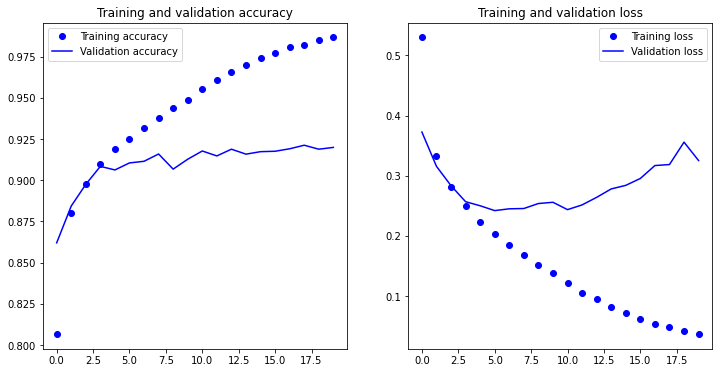

In [11]:
## put the model evaluation into perspective and plot the accuracy and loss plots between training and validation data
accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(epochs, accuracy, 'bo', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.title.set_text('Training and validation accuracy')
ax1.legend()
#plt.figure()
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

#### A few techniques that can reduce overfitting:
    * Regularisation of data (L1 or L2).
    * Dropouts — Randomly dropping connections between neurons, forcing the network to find new paths and generalise.
    * Early Stopping — Precipitates the training of the neural network, leading to reduction in error in the test set.

**You can add a dropout layer to overcome the problem of overfitting to some extent. Dropout randomly turns off a fraction of neurons during the training process, reducing the dependency on the training set by some amount.**

In a CNN, each neuron produces one feature map. Since dropout spatial dropout works per-neuron, dropping a neuron means that the corresponding feature map is dropped - e.g. each position has the same value (usually 0). So each feature map is either fully dropped or not dropped at all.

Pooling usually operates separately on each feature map, so it should not make any difference if you apply dropout before or after pooling. At least this is the case for pooling operations like maxpooling or averaging.

However, if you actually use element-wise dropout (which seems to be set as default for tensorflow), it actually makes a difference if you apply dropout before or after pooling. However, there is not necessarily a wrong way of doing it. Consider the average pooling operation: if you apply dropout before pooling, you effectively scale the resulting neuron activations by 1.0 - dropout_probability, but most neurons will be non-zero (in general). If you apply dropout after average pooling, you generally end up with a fraction of (1.0 - dropout_probability) non-zero "unscaled" neuron activations and a fraction of dropout_probability zero neurons. Both seems viable to me, neither is outright wrong.

[This tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) uses pooling before dropout and gets good results.


In [12]:
#################################
# The neural network architecture
#################################
# Adding dropout into the network
# sugguestion of using Dropout(rate = 0.25) in between and Dropout(rate = 0.4) before the last Dense layer
# below is just the copy of the cell above

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))#, kernel_regularizer=l2(0.01)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
####### after maxpooling
fashion_model.add(Dropout(0.25))  

fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))#, kernel_regularizer=l2(0.01)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
####### after maxpooling
fashion_model.add(Dropout(0.25))  

fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))#, kernel_regularizer=l2(0.01)))
fashion_model.add(LeakyReLU(alpha=0.1))             
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
####### after maxpooling
fashion_model.add(Dropout(0.25))  

fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))
####### after activation
fashion_model.add(Dropout(0.4))  
fashion_model.add(Dense(num_classes, activation='softmax')) 

In [13]:
### Model compiling

opt = keras.optimizers.Adam(learning_rate=0.0005) ## optimizer options: see https://keras.io/api/optimizers/
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt,metrics=['acc'])
fashion_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)         

In [14]:
#### some hyperparameters ######
batch_size = 64
epochs = 20

fashion_train_dropout = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.6929 - acc: 0.7440 - val_loss: 0.4280 - val_acc: 0.8428
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 0.4278 - acc: 0.8453 - val_loss: 0.3789 - val_acc: 0.8547
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3717 - acc: 0.8632 - val_loss: 0.3226 - val_acc: 0.8793
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3383 - acc: 0.8778 - val_loss: 0.2962 - val_acc: 0.8904
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 0.3178 - acc: 0.8834 - val_loss: 0.2809 - val_acc: 0.8957
Epoch 6/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2972 - acc: 0.8901 - val_loss: 0.2699 - val_acc: 0.8995
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.2831 - acc: 0.8952 - val_loss: 0.2604 - val_acc: 0.9045
Epoch 8/20
750/750 [==============================] - 4s 5ms/step - loss: 0.

In [15]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.2159 - acc: 0.9235
Test loss: 0.21588876843452454
Test accuracy: 0.9235000014305115


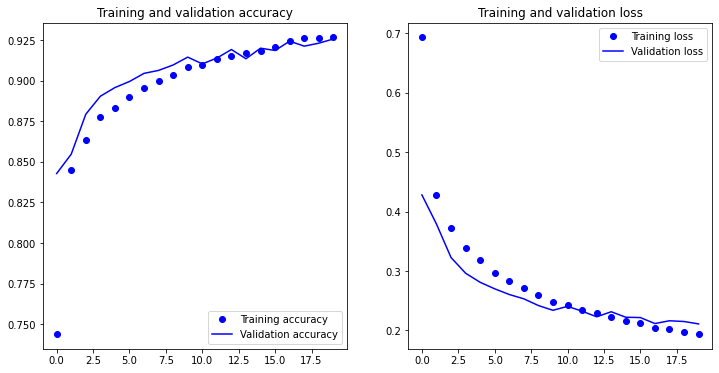

In [16]:
accuracy = fashion_train_dropout.history['acc']
val_accuracy = fashion_train_dropout.history['val_acc']
loss = fashion_train_dropout.history['loss']
val_loss = fashion_train_dropout.history['val_loss']
epochs = range(len(accuracy))
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(epochs, accuracy, 'bo', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.title.set_text('Training and validation accuracy')
ax1.legend()
#plt.figure()
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

When the input distribution to the layers of your neural network end up fluctuating. The internal part refers to the fact that this fluctuation is happening in the intermediate layers of the neural network, which can be thought of the internal part of the network. The covariate part refers to the fact that the distributions are parameterized by weights that vary with each other. Shift, well, means the distribution is changing.<br>
Using **Batch Normalization** to cccelerate deep network training by reducing internal covariate shift.


In [17]:
#################################
# The neural network architecture
#################################
# Adding dropout into the network
# Adding batch normalization layer, which is BatchNoarmalization(), in addition to dropout, into the network
# sugguestion of using Dropout(rate = 0.25) in between and Dropout(rate = 0.4) before the last Dense layer
# below is just the copy of the cell above

fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))#, kernel_regularizer=l2(0.01)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(BatchNormalization())
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
####### after maxpooling
fashion_model.add(Dropout(0.25))  

fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))#, kernel_regularizer=l2(0.01)))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(BatchNormalization())
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
####### after maxpooling
fashion_model.add(Dropout(0.25))  

fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))#, kernel_regularizer=l2(0.01)))
fashion_model.add(LeakyReLU(alpha=0.1))  
fashion_model.add(BatchNormalization())           
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
####### after maxpooling
fashion_model.add(Dropout(0.25))  

fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(BatchNormalization())
fashion_model.add(LeakyReLU(alpha=0.1))
####### after activation
fashion_model.add(Dropout(0.4))  
fashion_model.add(Dense(num_classes, activation='softmax')) 

In [18]:
### Model compiling
opt = keras.optimizers.Adam(learning_rate=0.0005) ## optimizer options: see https://keras.io/api/optimizers/
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt,metrics=['acc'])
fashion_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 64)       

In [ ]:
#### some hyperparameters ######
batch_size = 64
epochs = 20

fashion_train_dropout_batchnorm = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 0.5730 - acc: 0.7932 - val_loss: 0.3765 - val_acc: 0.8637
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.3779 - acc: 0.8634 - val_loss: 0.2830 - val_acc: 0.8957
Epoch 3/20
750/750 [==============================] - 4s 6ms/step - loss: 0.3307 - acc: 0.8813 - val_loss: 0.2724 - val_acc: 0.8994
Epoch 4/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2987 - acc: 0.8915 - val_loss: 0.2512 - val_acc: 0.9069
Epoch 5/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2804 - acc: 0.8976 - val_loss: 0.2574 - val_acc: 0.9044
Epoch 6/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2619 - acc: 0.9037 - val_loss: 0.2392 - val_acc: 0.9119
Epoch 7/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2532 - acc: 0.9080 - val_loss: 0.2540 - val_acc: 0.9076
Epoch 8/20
750/750 [==============================] - 4s 6ms/step - loss: 0.

In [ ]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [ ]:
accuracy = fashion_train_dropout_batchnorm.history['acc']
val_accuracy = fashion_train_dropout_batchnorm.history['val_acc']
loss = fashion_train_dropout_batchnorm.history['loss']
val_loss = fashion_train_dropout_batchnorm.history['val_loss']
epochs = range(len(accuracy))
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(epochs, accuracy, 'bo', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.title.set_text('Training and validation accuracy')
ax1.legend()
#plt.figure()
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.legend()
ax2.title.set_text('Training and validation loss')

### Data dearth dealing
There are many cases where the amount of training data available is restricted. If you are not able to collect more data then you could resort to data augmentation techniques.

#### <b>Question:</b>
Which of the followings does data augmentation do?

   A.  Adds more training data<br>
   B.  Replaces training data<br>
   C.  Does both<br>
   D.  I don’t know<br>


Technically, all the answers are correct — but the only way you know if a given definition of data augmentation is correct is via the context of its application.

#### **What is data augmentation?**

Data augmentation encompasses a wide range of techniques used to generate “new” training samples from the original ones by applying random jitters and perturbations (but at the same time ensuring that the class labels of the data are not changed).

Our goal when applying data augmentation is to increase the generalizability of the model.

Given that our network is constantly seeing new, slightly modified versions of the input data, the network is able to learn more robust features.

At testing time we do not apply data augmentation and simply evaluate our trained network on the unmodified testing data 

#### A simple data augmentation
![alt text](https://drive.google.com/uc?id=1Ne089ybJL1Bv7VmAJwYJjDwkYcx7uHEF)

**Left:** A sample of 250 data points that follow a normal distribution exactly.<br> **Right:** Adding a small amount of random “jitter” to the distribution. This type of data augmentation increases the generalizability of our networks.<br>

In the context of computer vision, we can obtain augmented data by applying simple geometric transforms, for example:<br>
*random* <br>
> translations<br>
> rotation<br>
> scaling<br>
> shearing<br>
> horizontal/ vertical flips




### Hyperparameter tuning
Instead of trying different values by hand, we will use ***GridSearchCV*** from ***Scikit-Learn*** to try out several values for our hyperparameters and compare the results. <br>
To do cross-validation with **keras**, we will use the wrappers for the Scikit-learn API.<br>
There are two warppers available:
<font color='red'>keras.wrappers.scikit_learn.KerasClassifier(build_fn=None, **sk_parms)</font>, which implements the Scikit-learn classifier interface,<br>
<font color='red'>keras.wrappers.scikit_learn.KerasRegressor(build_fn=None, **sk_params)</font>, which implemens the Scikit-learn regressor interface.


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#### Trying different weight initializations
The first parameter we will try to optimized via cross-validation is different weight initializations.

In [ ]:
## Let's create a function that crteates the model while accepting the hyperparameters we want to tune

num_classes = 10
#################################
# The neural network architecture
#################################
def create_model(init_mode = 'uniform'):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same', kernel_initializer=init_mode))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D((2, 2),padding='same'))
  model.add(Conv2D(64, (3, 3), activation='linear',padding='same', kernel_initializer=init_mode))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Conv2D(128, (3, 3), activation='linear',padding='same', kernel_initializer=init_mode))
  model.add(LeakyReLU(alpha=0.1))                  
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Flatten())
  model.add(Dense(128, activation='linear', kernel_initializer=init_mode))
  model.add(LeakyReLU(alpha=0.1))   
  model.add(Dense(num_classes, activation='softmax', kernel_initializer=init_mode))    
  
  ## compile model
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=['acc'])
  
  return model         

In [ ]:
seed = 8
batch_size = 64
epochs = 10

np.random.seed(seed)

model_CV = KerasClassifier(build_fn=create_model, epochs = epochs, batch_size = batch_size, verbose = 1)
## define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode = init_mode)
grid = GridSearchCV(estimator = model_CV, param_grid = param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_label)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/10
750/750 [==============================] - 3s 4ms/step - loss: 0.5147 - acc: 0.8110
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.3240 - acc: 0.8829
Epoch 3/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2771 - acc: 0.8986
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2473 - acc: 0.9097
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2231 - acc: 0.9184
Epoch 6/10
750/750 [==============================] - 3s 4ms/step - loss: 0.2031 - acc: 0.9249
Epoch 7/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1846 - acc: 0.9323
Epoch 8/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1657 - acc: 0.9399
Epoch 9/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1493 - acc: 0.9451
Epoch 10/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1339 - acc: 0.9500


In [ ]:
#print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9131249984105428 using {'init_mode': 'lecun_uniform'}
 mean=0.9049, std=0.00358 using {'init_mode': 'uniform'}
 mean=0.9131, std=0.0024 using {'init_mode': 'lecun_uniform'}
 mean=0.9115, std=0.001242 using {'init_mode': 'normal'}
 mean=0.09787, std=0.0007722 using {'init_mode': 'zero'}
 mean=0.9098, std=0.006815 using {'init_mode': 'glorot_normal'}
 mean=0.9113, std=0.006546 using {'init_mode': 'glorot_uniform'}
 mean=0.912, std=0.002553 using {'init_mode': 'he_normal'}
 mean=0.9117, std=0.0005915 using {'init_mode': 'he_uniform'}


#### cross-validation with more than one hyperparameter
We can do cross-validation with more than one parameters simultaneously, effectively trying out combinations of them.<br>
**Note: Cross-validation in neural networks is computationally expensive.**


In [ ]:
### Let's perform a GridSearch for batch size and initializer combined now.
### First, create a function that creates the model (required for KerasClassifier) 
### while accepting the hyperparameters we want to tune 
### we also pass some default values such as optimizer='Adam'

def create_model2(optimizer ='Adam', init = 'glorot_uniform'):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D((2, 2),padding='same'))
  model.add(Conv2D(64, (3, 3), activation='linear',padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Conv2D(128, (3, 3), activation='linear',padding='same', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.1))                  
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Flatten())
  model.add(Dense(128, activation='linear', kernel_initializer=init))
  model.add(LeakyReLU(alpha=0.1))   
  model.add(Dense(num_classes, activation='softmax', kernel_initializer=init))    
  ## compile model
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer ,metrics=['acc'])
  
  return model 

In [ ]:
seed = 8
batch_size = [32, 64, 128]
epochs = 5

np.random.seed(seed)

model_CV = KerasClassifier(build_fn=create_model2, epochs = epochs, verbose = 1)
## define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
params_grid = dict(init = init_mode, batch_size = batch_size)
grid = GridSearchCV(estimator = model_CV, param_grid = params_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_X, train_label)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Epoch 1/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4060 - acc: 0.8529
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2576 - acc: 0.9042
Epoch 3/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2071 - acc: 0.9232
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1767 - acc: 0.9346
Epoch 5/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1479 - acc: 0.9445


In [ ]:
#print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.9151458144187927 using {'batch_size': 32, 'init': 'lecun_uniform'}
 mean=0.904, std=0.004116 using {'batch_size': 32, 'init': 'uniform'}
 mean=0.9151, std=0.001328 using {'batch_size': 32, 'init': 'lecun_uniform'}
 mean=0.9095, std=0.002541 using {'batch_size': 32, 'init': 'normal'}
 mean=0.09835, std=0.0001932 using {'batch_size': 32, 'init': 'zero'}
 mean=0.9091, std=0.001673 using {'batch_size': 32, 'init': 'glorot_normal'}
 mean=0.9113, std=0.002432 using {'batch_size': 32, 'init': 'glorot_uniform'}
 mean=0.9074, std=0.001575 using {'batch_size': 32, 'init': 'he_normal'}
 mean=0.9108, std=0.002207 using {'batch_size': 32, 'init': 'he_uniform'}
 mean=0.8975, std=0.002484 using {'batch_size': 64, 'init': 'uniform'}
 mean=0.9077, std=0.004066 using {'batch_size': 64, 'init': 'lecun_uniform'}
 mean=0.9003, std=0.001083 using {'batch_size': 64, 'init': 'normal'}
 mean=0.09765, std=0.000598 using {'batch_size': 64, 'init': 'zero'}
 mean=0.9089, std=0.001229 using {'ba

### Algorithm ensemble
If individual neural networks are not as accurate as you want, you can create an ensemble of neural networks and combine their predictive power. For example:
* Choose different neural network architectures
* Train them on different parts of the data
* Ensemble them and use their collective predictive power to get high accuracy on test data. 

In [ ]:
### Supposedly you are building a cats vs dogs classifier, 0-cat and 1-dog. 
### When combining different cats vs dogs classifiers, 
### the accuracy of the ensemble algorithm increases based on the Pearson Correlation between the individual classifiers.

### Let's look at the example below,
'''
Ground Truth: 1111111111
Classifier 1: 1111111100 = 80% accuracy
Classifier 2: 1111111100 = 80% accuracy
Classifier 3: 1011111100 = 70% accuracy
'''
from scipy.stats import pearsonr as pr

grnd_tru = [1,1,1,1,1,1,1,1,1,1]
clfr1 = [1,1,1,1,1,1,1,1,0,0]
clfr2 = [1,1,1,1,1,1,1,1,0,0]
clfr3 = [1,0,1,1,1,1,1,1,0,0]

r12, __ = pr(clfr1, clfr2)
r13, __ = pr(clfr1, clfr3)
r23, __ = pr(clfr2, clfr3)
print('r12: %f, r13: %f, r23: %f' %(r12, r13, r23))

### The Pearson Correlation of the three models is high. Therefore, ensembling them does not improve the accuracy. 
### If we ensemble the above three models using a majority vote, we get the following result.

ensemble = [int((cl1+cl2+cl3)/3 > 0.5) for cl1, cl2, cl3 in zip(clfr1, clfr2, clfr3)]
acc = [x == y for x, y in zip(grnd_tru, ensemble)]
accuracy = sum(acc)/len(acc)
print('accuracy =', accuracy)

r12: 1.000000, r13: 0.763763, r23: 0.763763
accuracy = 0.8


In [ ]:
### Now let's look at three models having a very low Person Correlation between their outputs.
'''
Ground Truth: 1111111111
Classifier 1: 1111111100 = 80% accuracy
Classifier 2: 0111011101 = 70% accuracy
Classifier 3: 1000101111 = 60% accuracy
'''
grnd_tru = [1,1,1,1,1,1,1,1,1,1]
clfr1 = [1,1,1,1,1,1,1,1,0,0]
clfr2 = [0,1,1,1,0,1,1,1,0,1]
clfr3 = [1,0,0,0,1,0,1,1,1,1]

r12, __ = pr(clfr1, clfr2)
r13, __ = pr(clfr1, clfr3)
r23, __ = pr(clfr2, clfr3)
print('r12: %f, r13: %f, r23: %f' %(r12, r13, r23))

###When we ensemble these three weak learners, we get the following result.
ensemble = [int((cl1+cl2+cl3)/3 > 0.5) for cl1, cl2, cl3 in zip(clfr1, clfr2, clfr3)]
acc = [x == y for x, y in zip(grnd_tru, ensemble)]
accuracy = sum(acc)/len(acc)
print('accuracy =', accuracy)

r12: 0.218218, r13: -0.408248, r23: -0.534522
accuracy = 0.9


#### An ensemble of weak learners with low Pearson Correlation is able to outperform an ensemble with high Pearson Correlation between them.

#### Exercise:
Try to optimize the present model using:
* overfitting reduction -- dropout, regularizer (L1/ L2), etc.
* data augumentation
* hyperparameter tuning -- grid search of hyperparameters including batch size, optimizer, weight initilization
* algorithm (model) ensemble